# Streamfunction-vorticity formulation

definitions

$$\textbf{u}=\nabla\times\boldsymbol{\psi} \iff \nabla\cdot\textbf{u}=0$$

$$\boldsymbol{\omega}=\nabla\times\textbf{u}$$

## Streamfunction-vorticity formulation of Navier-Stokes equations

initial value problem on $(\textbf{x}, t)\in\Omega\times[0,\infty)$

$$\nabla\cdot\textbf{u}=0$$

$$\rho \left(\frac{\partial\textbf{u}}{\partial t}+\textbf{u}\cdot\nabla\textbf{u}\right)=-\nabla p + \mu\nabla^2\textbf{u} + \textbf{f}(\textbf{x}, t)$$

streamfunction-vorticity formulation with constant $\rho$ and $\mu$

$$\rho\left(\frac{\partial\boldsymbol{\omega}}{\partial t}+(\nabla\times\boldsymbol{\psi})\cdot\nabla\boldsymbol{\omega} - \boldsymbol{\omega}\cdot\nabla(\nabla\times\boldsymbol{\psi})\right)=\mu\nabla^2\boldsymbol{\omega} + \nabla\times\textbf{f}$$

$$\boldsymbol{\omega}=\nabla\times(\nabla\times\boldsymbol{\psi})$$

$d=2$ Cartesian formulation

$$\textbf{u}=\nabla\times\psi\textbf{e}_z=-\frac{\partial\psi}{\partial y}\textbf{e}_x + \frac{\partial\psi}{\partial x}\textbf{e}_y$$

$$\boldsymbol{\omega}=\omega\textbf{e}_z=\left(\frac{\partial u_y}{\partial x} - \frac{\partial u_x}{\partial y}\right)\textbf{e}_z$$

$$\nabla^2\psi=\omega$$

$$\rho\left(\frac{\partial\omega}{\partial t}+\left(-\frac{\partial\psi}{\partial y}, \frac{\partial\psi}{\partial x}\right)\cdot\nabla\omega\right)=\mu\nabla^2\omega + \frac{\partial f_y}{\partial x} - \frac{\partial f_x}{\partial y}$$

initial conditions

$$\omega(\textbf{x}, t=0)=\omega_0(\textbf{x})$$

boundary conditions on $\textbf{x}\in\partial\Omega$ with unit normal $\textbf{n}\in\{\pm\textbf{e}_x, \pm\textbf{e}_y\}$ and unit tangent $\textbf{t}\in\{\pm\textbf{e}_y, \pm\textbf{e}_x\}$

$$\textbf{n}\cdot\textbf{u}\vert_{\partial\Omega}=0 \iff \psi\vert_{\partial\Omega}=0$$

$$\textbf{n}\cdot\nabla(\textbf{t}\cdot\textbf{u})\vert_{\partial\Omega}=0 \iff \omega\vert_{\partial\Omega}=0$$

In [ ]:
import numpy as np
from ufl.core.expr import Expr
from ufl import Form, dx, TestFunction, TrialFunction, as_matrix

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fdm import (
    FunctionSeries, ConstantSeries, FiniteDifference, AB1, CN, DT, 
    finite_difference_order, cfl_timestep,
)
from lucifex.fdm.ufl_operators import grad, inner, Dx
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, ibvp_solver, interpolation_solver, eval_solver, BoundaryConditions
from lucifex.utils import CellType
from lucifex.sim import configure_simulation, integrate
from lucifex.viz import plot_colormap, plot_contours
from lucifex.io import write


def streamfunction_velocity(psi: Function) -> Expr:
    return as_matrix([[0, 1], [-1, 0]]) * grad(psi)

def streamfunction_poisson(
    psi: Function,
    omega: Function,
) -> tuple[Form, Form]:
    v = TestFunction(psi.function_space)
    psi_trial = TrialFunction(psi.function_space)
    F_lhs = -inner(grad(v), grad(psi_trial)) * dx
    F_rhs = -v * omega * dx
    return F_lhs, F_rhs

def vorticity_transport(
    omega: FunctionSeries,
    dt: Constant,
    u: FunctionSeries,
    rho: Constant,
    mu: Constant,
    D_adv: FiniteDifference,
    D_diff: FiniteDifference,
    fx: Function | None = None,
    fy: Function | None = None,
) ->list[Form]:
    v = TestFunction(omega.function_space)
    Ft = v * rho * DT(omega, dt) * dx
    Fa = v * rho * D_adv(inner(u, grad(omega))) * dx
    Fd = inner(grad(v), mu * grad(D_diff(omega))) * dx
    forms = [Ft, Fa, Fd]
    if fx is not None:
        F_fx = v * Dx(fx, 1) * dx
        forms.append(F_fx)
    if fy is not None:
        F_fy = -v * Dx(fy, 0) * dx
        forms.append(F_fy)
    return forms

## Example: $d=2$ Navier-Stokes streamfunction-vorticity in a rectangle 

$$\Omega = [0, L_x] \times [0, L_y]$$
$$f_x = 0$$
$$f_y = 5y\sin(6\pi x/L_x)$$


In [16]:
@configure_simulation(
    store_step=1,
    write_step=None,
)
def streamfunction_vorticity_2d(
    Lx: float = 1.0,
    Ly: float = 1.0,
    Nx: int = 100,
    Ny: int = 100,
    cell: str = CellType.QUADRILATERAL,
    dt_max: float = 0.1,
    dt_min: float = 0.0,
    cfl_courant: float = 0.75,
    D_adv: FiniteDifference | tuple[FiniteDifference, FiniteDifference] = AB1,
    D_diff: FiniteDifference = CN,
):
    order = finite_difference_order(D_adv, D_diff)
    mesh = rectangle_mesh(Lx, Ly, Nx, Ny, cell)
    boundary = mesh_boundary(
        mesh, 
        {
            "left": lambda x: x[0],
            "right": lambda x: x[0] - Lx,
            "lower": lambda x: x[1],
            "upper": lambda x: x[1] - Ly,
        },
    )

    t = ConstantSeries(mesh, 't', ics=0.0)
    dt = ConstantSeries(mesh, 'dt')
    psi = FunctionSeries((mesh, 'P', 2), 'psi', order)
    omega = FunctionSeries((mesh, 'P', 1), 'omega', order, ics=0.0)
    u = FunctionSeries((mesh, 'P', 1, 2), 'u', order)

    rho = Constant(mesh, 1.0, name='rho')
    mu = Constant(mesh, 1.0, name='mu')

    fx = None
    fy = Function(
        (mesh, 'P', 1), 
        lambda x: 5 * x[1] * np.sin(6 * np.pi * x[0] / Lx),
        name='fy',
    )

    psi_bcs = BoundaryConditions(("dirichlet", boundary.union, 0.0))
    psi_solver = bvp_solver(streamfunction_poisson, psi_bcs)(psi, omega[0])

    u_solver = interpolation_solver(u, streamfunction_velocity)(psi[0])

    dt_solver = eval_solver(dt, cfl_timestep)(
        u[0], 'hmin', cfl_courant, dt_max, dt_min,
    )

    omega_bcs = BoundaryConditions(("dirichlet", boundary.union, 0.0))
    omega_solver = ibvp_solver(vorticity_transport, bcs=omega_bcs)(
        omega, dt[0], u, rho, mu, D_adv, D_diff, fx, fy)
    
    solvers = [psi_solver, u_solver, dt_solver, omega_solver]
    namespace = [rho, mu, fy]

    return solvers, t, dt, namespace


In [17]:
simulation = streamfunction_vorticity_2d(
    Lx=1.0,
    Ly=1.0,
    Nx=64,
    Ny=64,
)

n_stop = 100
dt_init = 1e-6
n_init = 5
integrate(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

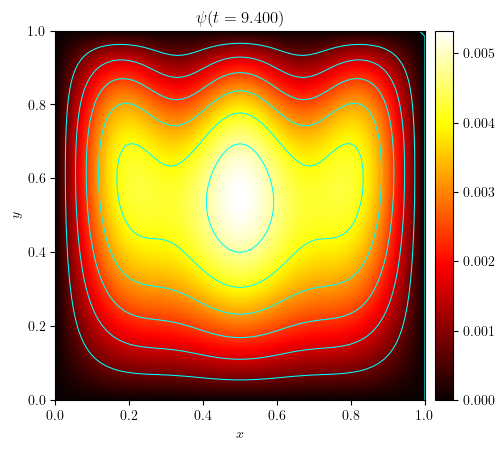

In [19]:
psi = simulation['psi']
time_index = -1

fig, ax = plot_colormap(psi.series[-1], title=f'$\psi(t={psi.time_series[-1]:.3f})$', x_label='$x$', y_label='$y$')
plot_contours(fig, ax, psi.series[time_index], use_cache=True, colors='cyan')
write(fig, f'A20_streamfunction_vorticity_navier_stokes', './figures', close=False, pickle=False)